In [2]:
# Import necessary libraries
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import fisher_exact, ranksums, spearmanr
from itertools import combinations
from statsmodels.stats.multitest import multipletests

from datetime import datetime

# Get current date formatted as yymmdd
formatted_date = datetime.now().strftime('%y%m%d')
clustering_resolution = 0.3

#os.chdir('/home/ak431480')

## Load data

In [2]:
adata = sc.read_h5ad('/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/preprocessed_h5ad/annotated_adata_obj_147180_cells_250813.h5ad')
adata.obs['type'] = adata.obs['type'].cat.reorder_categories(['PC','HSPC','CRPC'])

# Drop CRPCs
adata = adata[~(adata.obs['type'] == 'CRPC')]

# Drop Cycling cells
adata = adata[~(adata.obs['cell_type'] == 'Cycling cell')]

/home/ak431480/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata.obs_names_make_unique()

# Create an empty column to hold cluster assignments
adata.obs['celltype_leiden'] = None  

# Iterate over all cell types
for ctype in tqdm(adata.obs['cell_type'].unique()):
    print(f'Processing {ctype}...')
    adata_subset = adata[adata.obs['cell_type'] == ctype].copy()
    
    # Compute neighbors and Leiden within this subset
    sc.pp.neighbors(adata_subset, use_rep='X_pca_harmony',random_state=24664712)
    sc.tl.leiden(adata_subset, resolution=0.3, key_added='leiden_tmp')
    
    # Map results back into the main object
    adata.obs.loc[adata_subset.obs_names, 'celltype_leiden'] = (
        ctype + '_' + adata_subset.obs['leiden_tmp'].astype(str)
    )


/home/ak431480/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
  0%|          | 0/7 [00:00<?, ?it/s]

Processing Endothelial cell...


/tmp/ipykernel_293387/655836350.py:13: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_subset, resolution=0.3, key_added='leiden_tmp')
 14%|█▍        | 1/7 [00:35<03:31, 35.29s/it]

Processing Epithelial cell...


 29%|██▊       | 2/7 [01:15<03:09, 37.94s/it]

Processing T cell...


 29%|██▊       | 2/7 [01:23<03:28, 41.65s/it]


KeyboardInterrupt: 

In [ ]:
# Drop cellular subtypes present with < 50 genes
drop_cell_subtypes = adata.obs['celltype_leiden'].value_counts()[adata.obs['celltype_leiden'].value_counts() < 50].index.to_list()

adata = adata[~(adata.obs['celltype_leiden'].isin(drop_cell_subtypes))]
n_types = len(adata.obs['celltype_leiden'].value_counts())
# Summary
print(f'{n_types} unique categories:')
adata.obs['celltype_leiden'].value_counts()

48 unique categories:


celltype_leiden
T cell_0              20237
T cell_1              15650
Epithelial cell_0     10367
Epithelial cell_1      8443
Epithelial cell_2      7089
Epithelial cell_3      6629
T cell_2               5888
Myeloid cell_0         4287
Myeloid cell_1         4060
Endothelial cell_0     3074
Epithelial cell_4      3046
Fibroblast_0           2818
Fibroblast_1           2349
Endothelial cell_1     2278
T cell_3               1850
Endothelial cell_2     1777
Myeloid cell_2         1766
T cell_4               1663
Endothelial cell_3     1404
T cell_5               1232
Fibroblast_2           1193
Epithelial cell_5      1118
Myeloid cell_3         1080
Epithelial cell_6      1031
B cell_0                952
Mast cell_0             788
B cell_1                615
Mast cell_1             603
T cell_6                529
T cell_7                516
B cell_2                496
Epithelial cell_7       494
B cell_3                486
Myeloid cell_4          478
B cell_4                478
Endo

In [ ]:
# Get the unnormalized counts as the x layer
adata.X = adata.raw.X.copy()

/home/ak431480/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/tmp/ipykernel_14605/4207892679.py:1: UserWarning: Trying to set a dense array with a sparse array on a view.Densifying the sparse array.This may incur excessive memory usage
  adata.X = adata.raw.X.copy()
/tmp/ipykernel_14605/4207892679.py:1: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata.X = adata.raw.X.copy()


In [ ]:
adata.write('./scs_data_clustered_annotated_250611_cellular_subtypes_for_cell2location.h5ad')

/home/ak431480/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


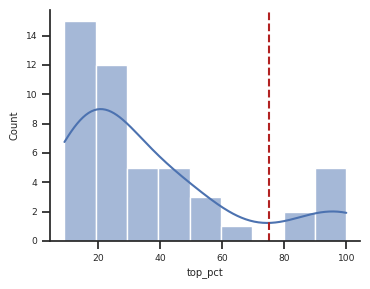

,top_sample,top_pct,n_unique_samples
celltype_leiden,,,
Epithelial cell_12,HSPC_S16,100.000000,1
Epithelial cell_10,HSPC_S26,100.000000,1
T cell_6,HSPC_S11,99.243856,5
B cell_7,HSPC_S11,98.192771,2
T cell_4,PC_S43,96.211666,12
Epithelial cell_8,PC_S37,88.888889,3
B cell_2,HSPC_S11,82.862903,10


In [ ]:
### Find clusters that are mostly from a single sample and most likely technological

obs_data = adata.obs.copy()

vcounts = obs_data['celltype_leiden'].value_counts()

results = []  # collect rows

for col in vcounts.index:
    samplecounts = (
        obs_data[obs_data['celltype_leiden'] == col]['sample']
        .value_counts(normalize=True)
    )
    top_pct = samplecounts.iloc[0]*100
    top_sample = samplecounts.index[0]
    results.append({
        'celltype_leiden': col,
        'top_sample': top_sample,
        'top_pct': top_pct,
        'n_unique_samples': len(samplecounts[samplecounts != 0])
    })

# Convert to DataFrame
summary_df = pd.DataFrame(results)
summary_df = summary_df.set_index('celltype_leiden')

# Sort by descending top_pct
summary_df = summary_df.sort_values(by='top_pct', ascending=False)

sns.set_theme(style='white',font_scale=0.6,rc={
    'xtick.bottom': True,
    'ytick.left': True})

fig,ax = plt.subplots(figsize=(4,3))
sns.histplot(summary_df['top_pct'],binwidth=10, kde=True, ax=ax)
ax.spines[['top','right']].set_visible(False)
ax.axvline(x=75,linestyle='--', color='firebrick')
plt.show()

clusters_to_drop = summary_df[summary_df['top_pct'] > 75].index.tolist()
summary_df.loc[clusters_to_drop]


In [ ]:
# Drop the clusters
adata = adata[~(adata.obs['celltype_leiden'].isin(clusters_to_drop))]

In [ ]:
adata.obs['celltype_leiden'].value_counts()

celltype_leiden
T cell_0              20237
T cell_1              15650
Epithelial cell_0     10367
Epithelial cell_1      8443
Epithelial cell_2      7089
Epithelial cell_3      6629
T cell_2               5888
Myeloid cell_0         4287
Myeloid cell_1         4060
Endothelial cell_0     3074
Epithelial cell_4      3046
Fibroblast_0           2818
Fibroblast_1           2349
Endothelial cell_1     2278
T cell_3               1850
Endothelial cell_2     1777
Myeloid cell_2         1766
Endothelial cell_3     1404
T cell_5               1232
Fibroblast_2           1193
Epithelial cell_5      1118
Myeloid cell_3         1080
Epithelial cell_6      1031
B cell_0                952
Mast cell_0             788
B cell_1                615
Mast cell_1             603
T cell_7                516
Epithelial cell_7       494
B cell_3                486
Myeloid cell_4          478
B cell_4                478
Endothelial cell_4      472
B cell_5                436
B cell_6                384
Epit

In [ ]:
# Get the unnormalized counts as the x layer
adata.X = adata.raw.X.copy()

/home/ak431480/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/tmp/ipykernel_539639/4015939341.py:2: UserWarning: Trying to set a dense array with a sparse array on a view.Densifying the sparse array.This may incur excessive memory usage
  adata.X = adata.raw.X.copy()
/tmp/ipykernel_539639/4015939341.py:2: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata.X = adata.raw.X.copy()


In [ ]:
# Save the adata object
adata.write(f'/scratch/svc_td_compbio/users/kiviaho/preprocessed_h5ad/lyu_2024_cell_subtypes_for_cell2location_mapping_{formatted_date}.h5ad')

## Calculate differential expression

In [ ]:
scs_adata = sc.read_h5ad('/scratch/svc_td_compbio/users/kiviaho/preprocessed_h5ad/lyu_2024_cell_subtypes_for_cell2location_mapping_251014.h5ad')
celltypes = scs_adata.obs['celltype_leiden'].value_counts().index.tolist()

In [ ]:
# One cluster vs all rest

output_path = "/home/ak431480/shafi_explant_project/scs_cluster_markers_vs_baseline_of_all_other.xlsx"
writer = pd.ExcelWriter(output_path, engine='openpyxl')

marker_genes_dict = {}
category_results = []
# First round: global DEGs
sc.tl.rank_genes_groups(
    scs_adata,
    groupby='celltype_leiden',
    reference='rest',
    layer='log1p',
    use_raw=False
)

for g in celltypes:
    deg_results_df = sc.get.rank_genes_groups_df(scs_adata, group=g, log2fc_min=1, pval_cutoff=0.05)
    deg_results_df['annotation'] = g  # mark which group this came from
    category_results.append(deg_results_df)

combined_df = pd.concat(category_results, ignore_index=True)
combined_df.to_excel(writer, sheet_name='DEGs', index=False)  # Excel sheet names max 31 chars

# Save workbook
writer.close()

print(f"Saved differential expression results to: {output_path}")


/home/ak431480/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/ak431480/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/ak431480/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:440: PerformanceWarning: DataFrame is highly fragme

Saved differential expression results to: /home/ak431480/shafi_explant_project/scs_cluster_markers_vs_baseline_of_all_other.xlsx


In [ ]:
output_path = "/home/ak431480/shafi_explant_project/scs_cluster_markers.xlsx"
writer = pd.ExcelWriter(output_path, engine='openpyxl')

marker_genes_dict = {}

# First round: global DEGs
sc.tl.rank_genes_groups(
    scs_adata,
    groupby='celltype_leiden',
    reference='rest',
    layer='log1p',
    use_raw=False
)

for g in celltypes:
    deg_results_df = sc.get.rank_genes_groups_df(scs_adata, group=g, log2fc_min=1, pval_cutoff=0.05)
    top_genes_str = '(' + ', '.join(deg_results_df['names'].tolist()[:3]) + ',\n'
    marker_genes_dict[g] = top_genes_str

# Second pass: within-category DEGs
top_level_categories = scs_adata.obs['cell_type'].cat.categories.tolist()

for top_category in top_level_categories:
    celltype_groups = [c for c in celltypes if top_category in c]

    adata = scs_adata[scs_adata.obs['celltype_leiden'].isin(celltype_groups)]
    sc.tl.rank_genes_groups(
        adata,
        groupby='celltype_leiden',
        groups=celltype_groups,
        reference='rest',
        layer='log1p',
        use_raw=False
    )

    category_results = []

    for g in celltype_groups:
        deg_results_df = sc.get.rank_genes_groups_df(adata, group=g, log2fc_min=1, pval_cutoff=0.05)
        deg_results_df['annotation'] = g  # mark which group this came from
        category_results.append(deg_results_df)

        # Update marker gene string
        marker_genes_dict[g] = marker_genes_dict[g] + ', '.join(deg_results_df['names'].tolist()[:3]) + ')'

    # Concatenate and save to Excel tab for this top_category
    if category_results:
        combined_df = pd.concat(category_results, ignore_index=True)
        combined_df.to_excel(writer, sheet_name=top_category[:31], index=False)  # Excel sheet names max 31 chars

# Save workbook
writer.close()

print(f"Saved differential expression results to: {output_path}")


/home/ak431480/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/ak431480/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/ak431480/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:440: PerformanceWarning: DataFrame is highly fragme

Saved differential expression results to: /home/ak431480/shafi_explant_project/scs_cluster_markers.xlsx


## Plot cluster markers on umap

In [ ]:
# Calculate the differentially expressed genes in each group, put them into a string
marker_genes_dict = {}

sc.tl.rank_genes_groups(scs_adata,
        groupby='celltype_leiden',
        reference='rest',
        layer='log1p',
        use_raw=False)

for g in celltypes:
        deg_results_df = sc.get.rank_genes_groups_df(scs_adata,group=g,log2fc_min=1,pval_cutoff=0.05)

        # Extract the genes with the top 3 highest scores
        top_genes_str = '(' + ', '.join(deg_results_df['names'].tolist()[:3]) + ',\n'

        marker_genes_dict[g] = top_genes_str

# Second pass, markers for within the celltype group
top_level_categories = scs_adata.obs['cell_type'].cat.categories.tolist()

for top_category in top_level_categories:

        celltype_groups = [c for c in celltypes if top_category in c]

        adata = scs_adata[scs_adata.obs['celltype_leiden'].isin(celltype_groups)]
        sc.tl.rank_genes_groups(adata,
                groupby='celltype_leiden',
                groups=celltype_groups,
                reference='rest',
                layer='log1p',
                use_raw=False)

        for g in celltype_groups:
                deg_results_df = sc.get.rank_genes_groups_df(adata,group=g,log2fc_min=1,pval_cutoff=0.05)

                # Extract the genes with the top 3 highest scores
                marker_genes_dict[g] = marker_genes_dict[g] + ', '.join(deg_results_df['names'].tolist()[:3]) + ')'


/home/ak431480/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/ak431480/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/ak431480/.local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:440: PerformanceWarning: DataFrame is highly fragme

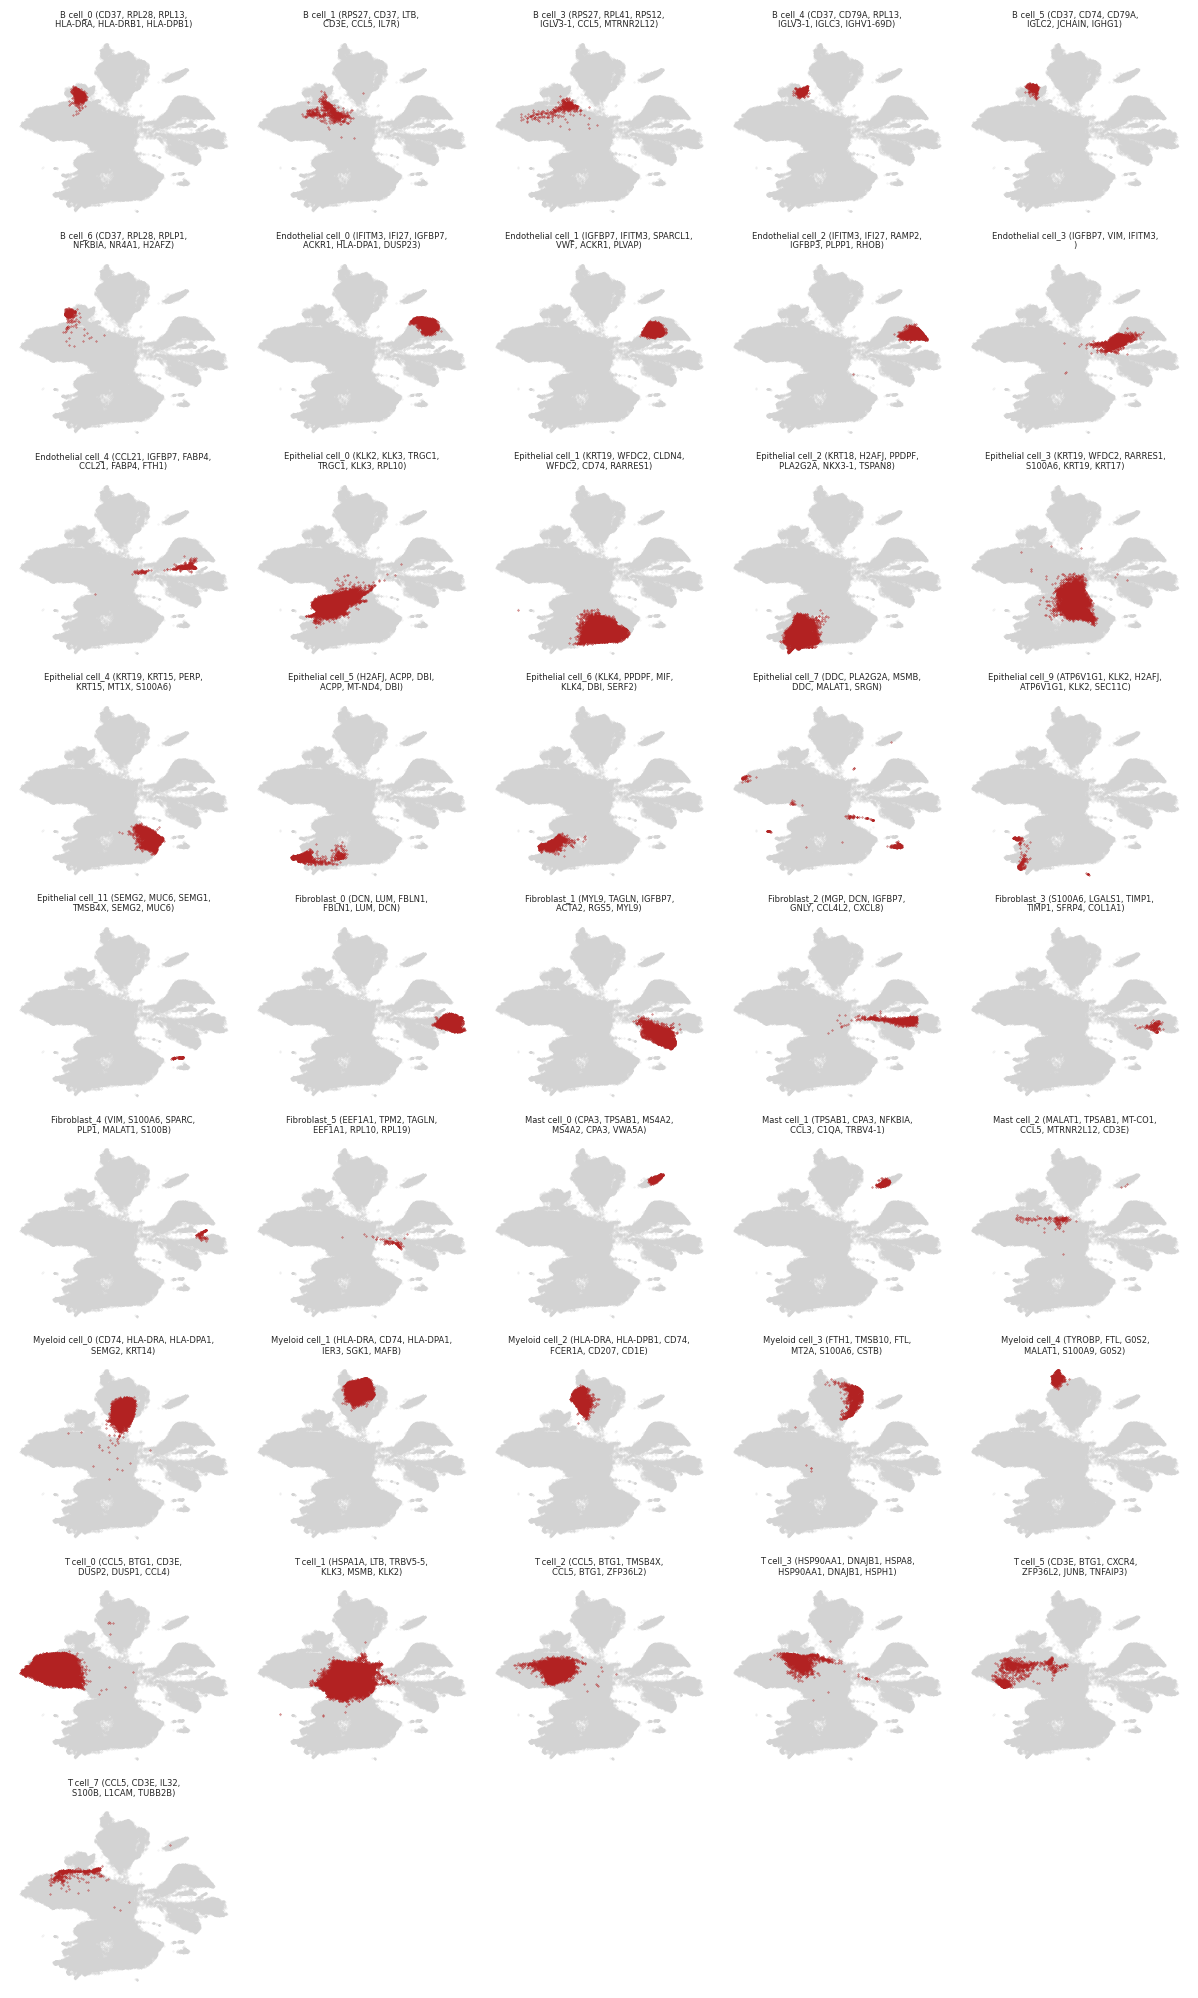

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

# ensure UMAP is computed
if 'X_umap' not in scs_adata.obsm:
    sc.tl.umap(scs_adata)

# extract coordinates
umap = scs_adata.obsm['X_umap']
clusters = scs_adata.obs['celltype_leiden'].cat.categories

# set up grid
fig, axes = plt.subplots(9, 5, figsize=(12, 20))
axes = axes.flatten()

for i, cluster in enumerate(clusters):
    ax = axes[i]
    
    highlight = scs_adata.obs['celltype_leiden'] == cluster

    # plot all cells in lightgray
    ax.scatter(umap[:, 0], umap[:, 1], s=0.1, color='lightgray', alpha=0.5, rasterized=True)
    # plot highlighted cluster in firebrick
    ax.scatter(umap[highlight, 0], umap[highlight, 1], s=0.1, color='firebrick', rasterized=True)

    ax.set_title(str(cluster) + ' ' + marker_genes_dict[cluster], fontsize=6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

# turn off extra axes if < 21 clusters
for j in range(len(clusters), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('/home/ak431480/shafi_explant_project/plots/scs_celltype_leiden_separately_highted_on_umap.pdf')
plt.show()


## Plot celltype fractions by treatment

In [3]:
scs_adata = sc.read_h5ad('/scratch/svc_td_compbio/users/kiviaho/preprocessed_h5ad/lyu_2024_cell_subtypes_for_cell2location_mapping_251014.h5ad')
scs_adata.obs_names = scs_adata.obs['sample'].astype(str) + '_' + scs_adata.obs_names

adata = scs_adata[scs_adata.obs['cell_type'] == 'Epithelial cell']

celltypes = scs_adata.obs['celltype_leiden'].value_counts().index.tolist()



In [4]:
prostate_lineage_signatures_dict = {}
prostate_lineage_signatures = pd.read_excel('/home/ak431480/prostate_lineage_signatures.xlsx',skiprows=1)
for gset in tqdm(prostate_lineage_signatures.columns):
    if 'Lum–' in gset:
        sig = prostate_lineage_signatures['Luminal'].dropna().tolist() + prostate_lineage_signatures[gset].dropna().tolist()
    if 'dLum' in gset:
        sig = prostate_lineage_signatures['Duct luminal'].dropna().tolist() + prostate_lineage_signatures[gset].dropna().tolist()
    if '_Basal' in gset:
        sig = prostate_lineage_signatures['Basal'].dropna().tolist() + prostate_lineage_signatures[gset].dropna().tolist()
    else:
        sig = prostate_lineage_signatures[gset].dropna().tolist()
    sc.tl.score_genes(adata,sig,score_name=gset,layer='log1p',use_raw=False)
    prostate_lineage_signatures_dict[gset] = prostate_lineage_signatures[gset].dropna().tolist()

celltype_order = adata.obs[['celltype_leiden','HALLMARK_ANDROGEN_RESPONSE']].groupby('celltype_leiden').median().sort_values('HALLMARK_ANDROGEN_RESPONSE',ascending=False).index.tolist()

  0%|          | 0/46 [00:00<?, ?it/s]/home/ak431480/.local/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
  2%|▏         | 1/46 [00:06<04:41,  6.26s/it]

 11%|█         | 5/46 [00:09<00:51,  1.27s/it]

 33%|███▎      | 15/46 [00:17<00:24,  1.27it/s]

 37%|███▋      | 17/46 [00:18<00:22,  1.28it/s]

 50%|█████     | 23/46 [00:23<00:17,  1.28it/s]

 54%|█████▍    | 25/46 [00:25<00:16,  1.28it/s]

 59%|█████▊    | 27/46 [00:26<00:14,  1.27it/s]

 61%|██████    | 28/46 [00:27<00:14,  1.26it/s]

 65%|██████▌   | 30/46 [00:29<00:12,  1.25it/s]

 67%|██████▋   | 31/46 [00:29<00:12,  1.25it/s]

 70%|██████▉   | 32/46 [00:30<00:11,  1.25it/s]

       'IFNA14', 'IFNA13', 'IFNA17', 'IFNA4', 'CCL3L3', 'IL9'],
      dtype='object')


 72%|███████▏  | 33/46 [00:31<00:10,  1.25it/s]

 74%|███████▍  | 34/46 [00:32<00:09,  1.27it/s]

 78%|███████▊  | 36/46 [00:33<00:07,  1.25it/s]

 80%|████████  | 37/46 [00:34<00:07,  1.24it/s]

 83%|████████▎ | 38/46 [00:35<00:06,  1.23it/s]

 85%|████████▍ | 39/46 [00:36<00:05,  1.24it/s]

 87%|████████▋ | 40/46 [00:37<00:04,  1.23it/s]

 91%|█████████▏| 42/46 [00:38<00:03,  1.22it/s]

 93%|█████████▎| 43/46 [00:39<00:02,  1.25it/s]

100%|██████████| 46/46 [00:41<00:00,  1.10it/s]
/tmp/ipykernel_233335/681836808.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_order = adata.obs[['celltype_leiden','HALLMARK_ANDROGEN_RESPONSE']].groupby('celltype_leiden').median().sort_values('HALLMARK_ANDROGEN_RESPONSE',ascending=False).index.tolist()


In [5]:
# Only keep cells with a positive CNV status
concat_obs_data = pd.read_csv('/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/preprocessed_h5ad/epithelial_cancer_cell_annotation_20250818.csv',index_col=0)
concat_obs_data.index =  concat_obs_data['sample'].astype(str) + '_' + concat_obs_data.index
cnv_adata = scs_adata[scs_adata.obs_names.isin(concat_obs_data[concat_obs_data['CNV_status'] == 'CNVpos cancer'].index.tolist())].copy()
adata.obs = pd.merge(adata.obs,concat_obs_data[['CNV_status']],left_index=True,right_index=True,how='left')
adata.obs['CNV_status'] = adata.obs['CNV_status'].fillna('Benign')

/tmp/ipykernel_233335/834032855.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sample', grpby, 'celltype_leiden'])
/tmp/ipykernel_233335/834032855.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_totals = sample_counts.groupby('sample')['count'].transform('sum')
/tmp/ipykernel_233335/834032855.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_counts.groupby('celltype_leiden')['fracti

      celltype_leiden  n_HSPC  n_PC      pval  pval_adj
0   Epithelial cell_5      18    10  0.000130  0.001296
1   Epithelial cell_6      18    10  0.000015  0.000152
2   Epithelial cell_9      18    10  1.000000  1.000000
3   Epithelial cell_2      18    10  0.000724  0.007243
4   Epithelial cell_1      18    10  0.002330  0.023300
5   Epithelial cell_0      18    10  0.000041  0.000414
6   Epithelial cell_4      18    10  0.010314  0.103138
7  Epithelial cell_11      18    10  0.022512  0.225122
8   Epithelial cell_7      18    10  0.221406  1.000000
9   Epithelial cell_3      18    10  0.005835  0.058350


/tmp/ipykernel_233335/834032855.py:83: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(
/tmp/ipykernel_233335/834032855.py:83: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/tmp/ipykernel_233335/834032855.py:83: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.2}` instead.

  sns.pointplot(


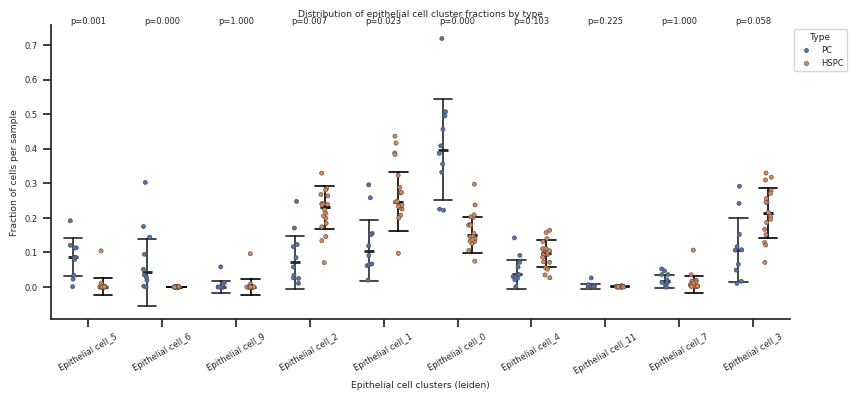

In [6]:
from scipy.stats import mannwhitneyu
ctype = 'Epithelial cell'
grpby = 'type'

sns.set_theme(style='white', font_scale=0.55, rc={
    'xtick.bottom': True,
    'ytick.left': True
})

# Copy and filter data
obs_data = adata.obs.copy()

obs_data = obs_data[obs_data['cell_type'] == ctype].copy()
obs_data['celltype_leiden'] = obs_data['celltype_leiden'].cat.remove_unused_categories()

vcounts = obs_data['sample'].value_counts()
obs_data = obs_data[obs_data['sample'].isin(vcounts[vcounts >=100].index)]
obs_data['sample'] = obs_data['sample'].cat.remove_unused_categories()

# Compute per-sample fractions
sample_counts = (
    obs_data
    .groupby(['sample', grpby, 'celltype_leiden'])
    .size()
    .reset_index(name='count')
)

# Normalize within each sample
sample_totals = sample_counts.groupby('sample')['count'].transform('sum')
sample_counts['fraction'] = sample_counts['count'] / sample_totals

sample_counts = sample_counts[~((sample_counts['sample'].str.contains('^HSPC_')) & (sample_counts['type'] == 'PC'))]
sample_counts = sample_counts[~((sample_counts['sample'].str.contains('^PC_')) & (sample_counts['type'] == 'HSPC'))]

# Sort celltypes by mean abundance
mean_fractions = (
    sample_counts.groupby('celltype_leiden')['fraction']
    .mean()
    .sort_values(ascending=False)
)

# ---- Statistical test per celltype_leiden ----
types = sample_counts[grpby].unique()
if len(types) != 2:
    raise ValueError(f"Expected exactly 2 types, found: {types}")

pvals = []
for celltype in celltype_order:
    data_sub = sample_counts[sample_counts['celltype_leiden'] == celltype]
    group1 = data_sub.loc[data_sub[grpby] == types[0], 'fraction'].dropna()
    group2 = data_sub.loc[data_sub[grpby] == types[1], 'fraction'].dropna()

    # Only test if both groups have >1 value
    if len(group1) > 0 and len(group2) > 0:
        stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    else:
        p = np.nan
    pvals.append({'celltype_leiden': celltype,
                  'n_' + types[0]: len(group1),
                  'n_' + types[1]: len(group2),
                  'pval': p})

pval_df = pd.DataFrame(pvals)
pval_df['pval_adj'] = pval_df['pval'] * len(pval_df)  # Bonferroni
pval_df['pval_adj'] = pval_df['pval_adj'].clip(upper=1.0)

print(pval_df)

# ---- Boxplot ----
plt.figure(figsize=(8, 4))
sns.stripplot(
    data=sample_counts,
    x='celltype_leiden',
    y='fraction',
    hue=grpby,
    order=celltype_order,
    dodge=True,
    #fliersize=0.5,
    linewidth=0.4,
    size=3,
)

sns.pointplot(
    data=sample_counts,
    x='celltype_leiden',
    y='fraction',
    hue=grpby,
    order=celltype_order,
    errorbar='sd',
    estimator='median',
    dodge=0.4,        # must match stripplot hue separation
    join=False,
    capsize=0.25,
    errwidth=1.2,
    markers='_',
    linestyles='',
    color='black',   # darker lines for contrast
    legend=False      # avoid double legend
)
# Annotate p-values above boxes
y_max = sample_counts['fraction'].max()
for i, row in enumerate(pval_df.itertuples()):
    label = f"p={row.pval_adj:.3f}" if not np.isnan(row.pval_adj) else "n/a"
    plt.text(i, y_max * 1.05, label, ha='center', va='bottom', fontsize=6)

plt.xlabel('Epithelial cell clusters (leiden)')
plt.ylabel('Fraction of cells per sample')
plt.title('Distribution of epithelial cell cluster fractions by type')
plt.xticks(rotation=30)
sns.despine()
plt.tight_layout()
plt.legend(title='Type', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


### Dotplot for gene markers

/tmp/ipykernel_227775/2912716517.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_order = obs_data[['celltype_leiden','Luminal']].groupby('celltype_leiden').median().sort_values('Luminal',ascending=False).index.tolist()


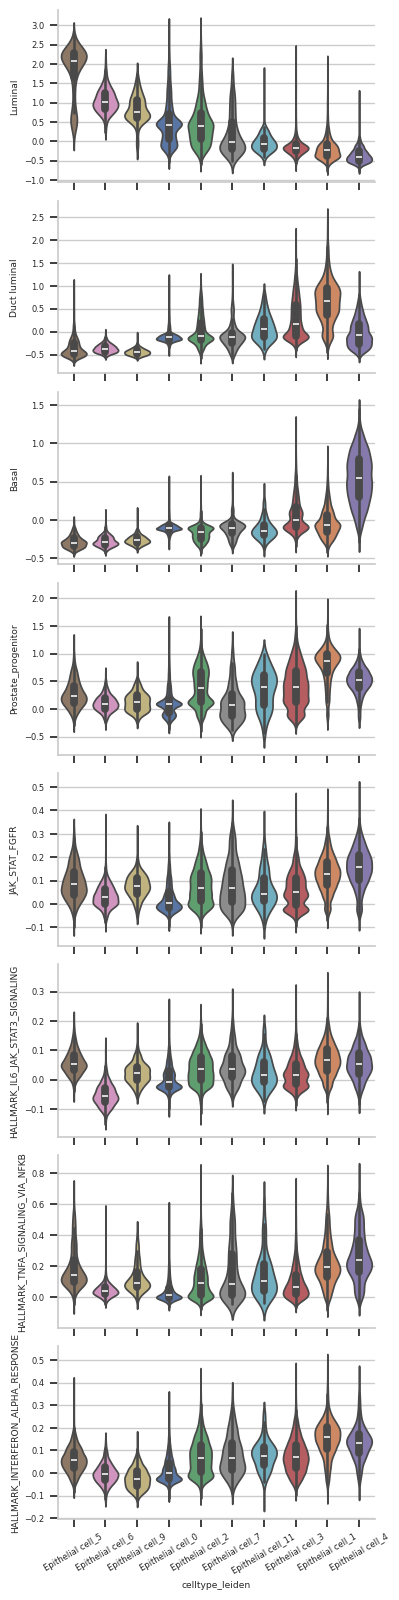

In [57]:
obs_data = adata.obs.copy()
celltype_order = obs_data[['celltype_leiden','Luminal']].groupby('celltype_leiden').median().sort_values('Luminal',ascending=False).index.tolist()

sns.set_theme(style='whitegrid', font_scale=0.55, rc={
    'xtick.bottom': True,
    'ytick.left': True
})


signatures = ['Luminal','Duct luminal','Basal','Prostate_progenitor','JAK_STAT_FGFR','HALLMARK_IL6_JAK_STAT3_SIGNALING','HALLMARK_TNFA_SIGNALING_VIA_NFKB','HALLMARK_INTERFERON_ALPHA_RESPONSE']

fig, axs = plt.subplots(len(signatures),1,figsize=(4,2*len(signatures)))
for i,signature in enumerate(signatures):

    ax = axs[i]
    sns.violinplot(
        obs_data,
        x = 'celltype_leiden',
        y= signature,
        hue = 'celltype_leiden',

        order = celltype_order,
        ax=ax
    )
    if i < len(signatures)-1:
        ax.set_xticklabels([])
        ax.set_xlabel('')
    ax.spines[['top','right']].set_visible(False)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

/tmp/ipykernel_233335/1608742794.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['bin', 'celltype_leiden'])


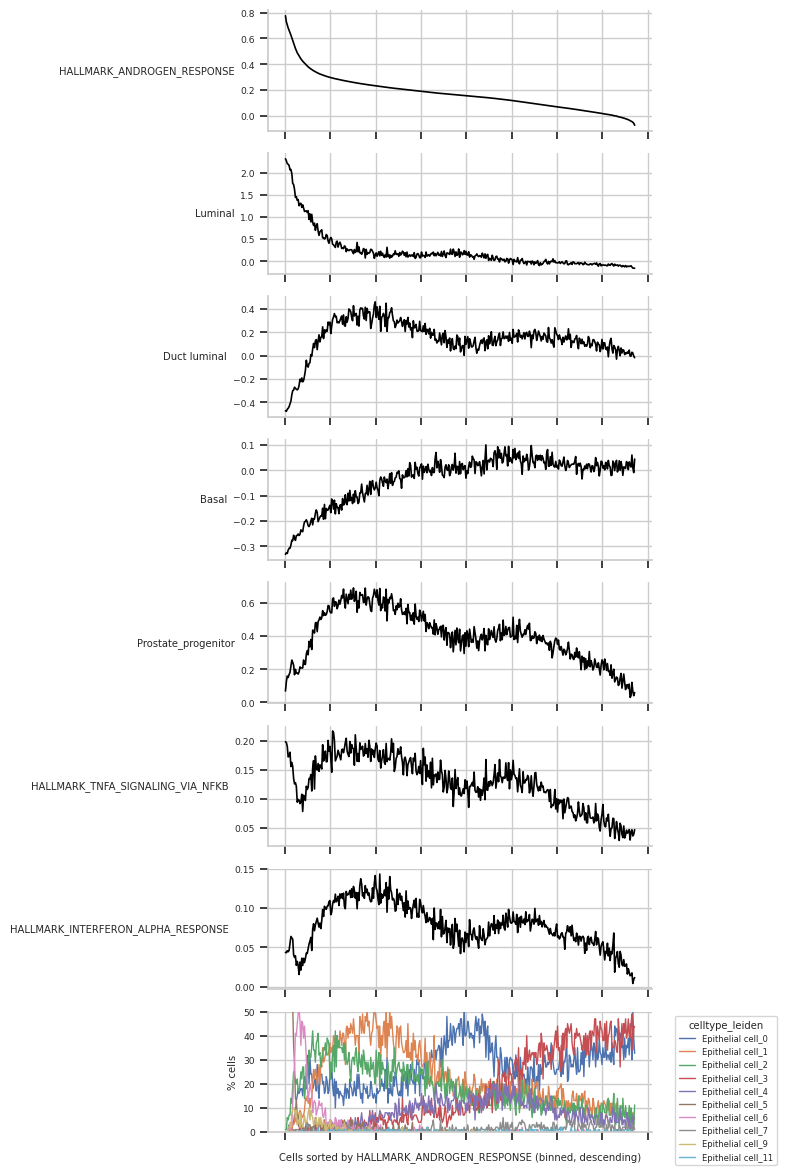

In [7]:
# Copy obs data
obs_data = adata.obs.copy()

# Sort cells by chosen signature (e.g. androgen response)
obs_data_sorted = obs_data.sort_values('HALLMARK_ANDROGEN_RESPONSE', ascending=False).reset_index(drop=True)

# Define number of cells per bin
bin_size = 100
obs_data_sorted['bin'] = obs_data_sorted.index // bin_size

# --- Compute mean per bin for all signatures ---
signatures = [
    'HALLMARK_ANDROGEN_RESPONSE',
    'Luminal', 'Duct luminal', 'Basal', 'Prostate_progenitor',
    'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_INTERFERON_ALPHA_RESPONSE'
]

binned_means = (
    obs_data_sorted
    .groupby('bin')[signatures]
    .mean()
    .reset_index()
)
binned_means['rank'] = binned_means['bin'] * bin_size + bin_size / 2  # midpoint of bin

# --- Compute % composition of each celltype_leiden per bin ---
celltype_fraction = (
    obs_data_sorted
    .groupby(['bin', 'celltype_leiden'])
    .size()
    .reset_index(name='count')
)

# Normalize to % within each bin
celltype_fraction['fraction'] = (
    celltype_fraction['count'] /
    celltype_fraction.groupby('bin')['count'].transform('sum') * 100
)

# Pivot to wide format: one column per celltype
celltype_fraction_wide = (
    celltype_fraction
    .pivot(index='bin', columns='celltype_leiden', values='fraction')
    .fillna(0)
    .reset_index()
)
celltype_fraction_wide['rank'] = celltype_fraction_wide['bin'] * bin_size + bin_size / 2

# --- Plot ---
sns.set_theme(style='whitegrid', font_scale=0.6, rc={
    'xtick.bottom': True,
    'ytick.left': True
})

fig, axs = plt.subplots(len(signatures) + 1, 1, figsize=(8, 1.5*(len(signatures)+1)), sharex=True)

# --- Plot each signature ---
for i, signature in enumerate(signatures):
    ax = axs[i]

    sns.lineplot(
        data=binned_means,
        x='rank',
        y=signature,
        color='black',
        lw=1.2,
        ax=ax
    )

    ax.set_ylabel(signature, rotation=0, ha='right', va='center')
    ax.spines[['top', 'right']].set_visible(False)
    if i < len(signatures):
        ax.set_xlabel('')
        ax.set_xticklabels([])

# --- Plot celltype composition on last axis ---
ax = axs[-1]

for ct in celltype_fraction_wide.columns:
    if ct in ['bin', 'rank']:
        continue
    sns.lineplot(
        data=celltype_fraction_wide,
        x='rank',
        y=ct,
        label=ct,
        lw=1,
        ax=ax
    )

ax.set_ylabel('% cells')
ax.set_ylim(0,50)
ax.set_xlabel('Cells sorted by HALLMARK_ANDROGEN_RESPONSE (binned, descending)')
ax.spines[['top', 'right']].set_visible(False)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6, title='celltype_leiden')

plt.tight_layout()
plt.show()


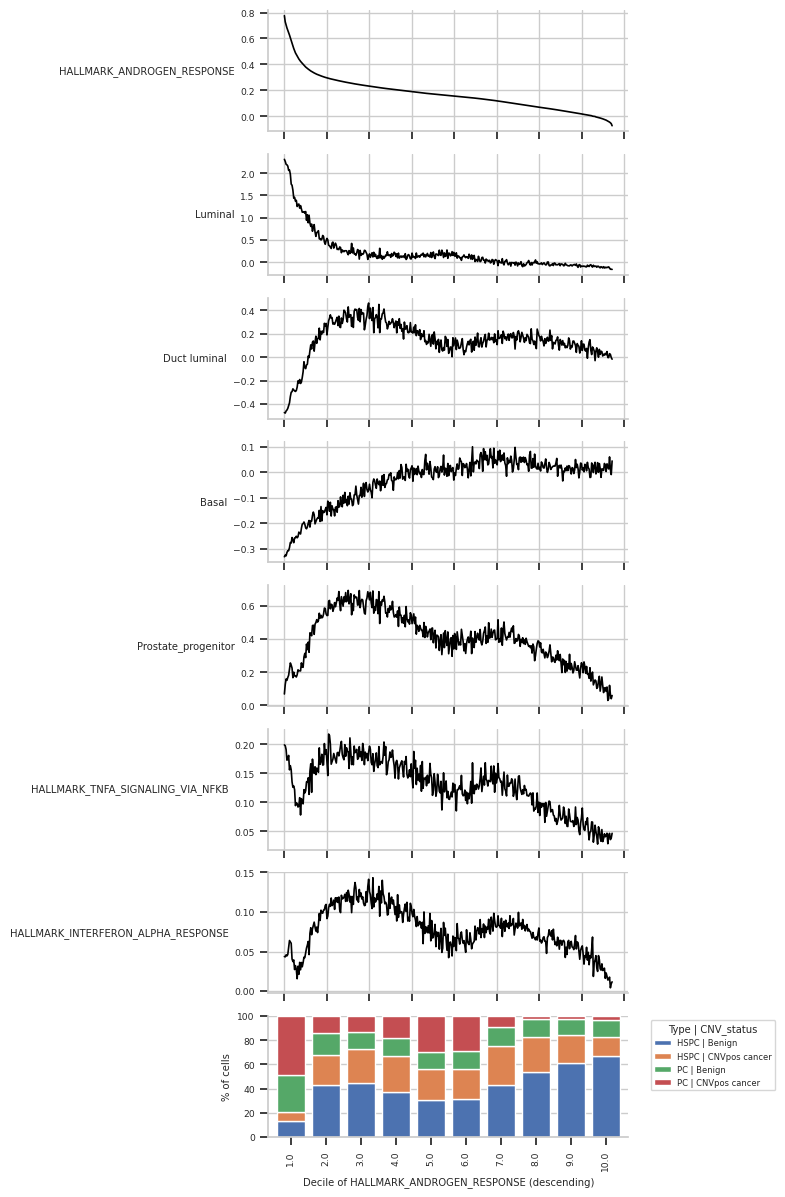

In [33]:
# --- Sort indices by signature for decile assignment ---
order = adata.obs['HALLMARK_ANDROGEN_RESPONSE'].sort_values(ascending=False).index

# --- Create decile vector (0–9) based on sorted order ---
decile_labels = pd.qcut(range(len(order)), 10, labels=False) + 1 # returns np.ndarray

# --- Map back to original adata.obs index order ---
adata.obs.loc[order, 'decile'] = decile_labels.astype(int)  # no .values needed

# --- Define 100-cell bins (for smoothed signature plotting) ---
adata.obs.loc[order, 'bin'] = (np.arange(len(order)) // 100).astype(int)

# --- Compute mean per 100-cell bin for selected signatures ---
signatures = [
    'HALLMARK_ANDROGEN_RESPONSE',
    'Luminal', 'Duct luminal', 'Basal', 'Prostate_progenitor',
    'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_INTERFERON_ALPHA_RESPONSE'
]

binned_means = (
    adata.obs.loc[order]
    .groupby('bin')[signatures]
    .mean()
    .reset_index()
)
binned_means['rank'] = binned_means['bin'] * 100 + 50  # midpoint of bin

# --- Combine 'type' and 'CNV_status' into one column ---
adata.obs['type_CNV'] = adata.obs['type'].astype(str) + ' | ' + adata.obs['CNV_status'].astype(str)

# --- Compute fractions per decile for the combined category ---
def compute_fractions(df, group_col):
    frac = (
        df.groupby(['decile', group_col])
        .size()
        .reset_index(name='count')
    )
    frac['fraction'] = frac['count'] / frac.groupby('decile')['count'].transform('sum') * 100
    frac_wide = frac.pivot(index='decile', columns=group_col, values='fraction').fillna(0)
    frac_wide['rank'] = frac_wide.index
    return frac_wide

combined_fraction = compute_fractions(adata.obs, 'type_CNV')

# --- Plot setup ---
sns.set_theme(style='whitegrid', font_scale=0.6, rc={'xtick.bottom': True, 'ytick.left': True})

fig, axs = plt.subplots(len(signatures) + 1, 1, figsize=(8, 1.5*(len(signatures)+1)), sharex=False)

# --- Plot each signature as line (100-cell bins) ---
for i, signature in enumerate(signatures):
    ax = axs[i]
    sns.lineplot(
        data=binned_means,
        x='rank',
        y=signature,
        color='black',
        lw=1.2,
        ax=ax
    )
    ax.set_ylabel(signature, rotation=0, ha='right', va='center')
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel('')
    ax.set_xticklabels([])

# --- Stacked barplot for combined 'type|CNV_status' ---
ax = axs[len(signatures)]
combined_fraction.plot(
    x='rank',
    kind='bar',
    stacked=True,
    ax=ax,
    width=0.8
)
ax.set_ylabel('% of cells')
ax.set_xlabel('Decile of HALLMARK_ANDROGEN_RESPONSE (descending)')
ax.set_ylim(0, 100)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6, title='Type | CNV_status')

plt.tight_layout()
plt.show()


/tmp/ipykernel_233335/282504363.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sample', grpby, 'decile'])
/tmp/ipykernel_233335/282504363.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_totals = sample_counts.groupby('sample')['count'].transform('sum')
/tmp/ipykernel_233335/282504363.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_counts.groupby('decile')['fraction']


   decile  n_HSPC  n_PC      pval  pval_adj
0     1.0      18    10  0.000425  0.004250
1     2.0      18    10  0.486916  1.000000
2     3.0      18    10  0.302613  1.000000
3     4.0      18    10  0.325657  1.000000
4     5.0      18    10  0.240121  1.000000
5     6.0      18    10  0.017628  0.176279
6     7.0      18    10  0.001430  0.014305
7     8.0      18    10  0.001687  0.016867
8     9.0      18    10  0.015466  0.154655
9    10.0      18    10  0.022741  0.227407


/tmp/ipykernel_233335/282504363.py:83: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(
/tmp/ipykernel_233335/282504363.py:83: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/tmp/ipykernel_233335/282504363.py:83: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.2}` instead.

  sns.pointplot(


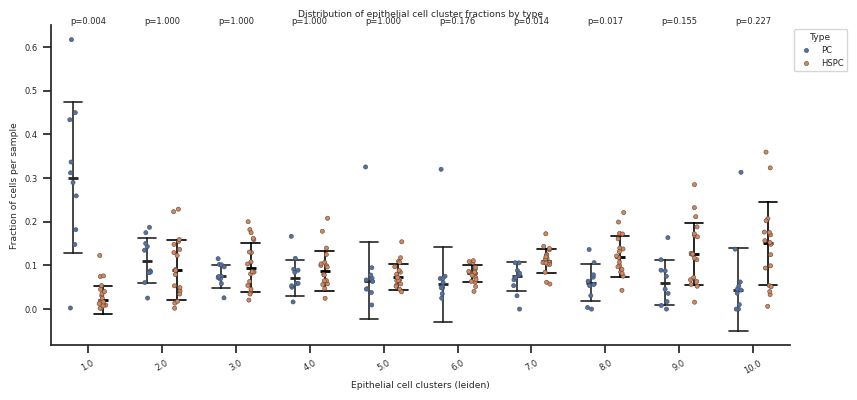

In [67]:
from scipy.stats import mannwhitneyu
ctype = 'Epithelial cell'
grpby = 'type'

sns.set_theme(style='white', font_scale=0.55, rc={
    'xtick.bottom': True,
    'ytick.left': True
})

# Copy and filter data
obs_data = adata.obs.copy()
#obs_data = obs_data[obs_data['CNV_status'] == 'CNVpos cancer']
obs_data = obs_data[obs_data['cell_type'] == ctype].copy()
obs_data['decile'] = pd.Categorical(obs_data['decile'])


vcounts = obs_data['sample'].value_counts()
obs_data = obs_data[obs_data['sample'].isin(vcounts[vcounts >=100].index)]
obs_data['sample'] = obs_data['sample'].cat.remove_unused_categories()

# Compute per-sample fractions
sample_counts = (
    obs_data
    .groupby(['sample', grpby, 'decile'])
    .size()
    .reset_index(name='count')
)

# Normalize within each sample
sample_totals = sample_counts.groupby('sample')['count'].transform('sum')
sample_counts['fraction'] = sample_counts['count'] / sample_totals

sample_counts = sample_counts[~((sample_counts['sample'].str.contains('^HSPC_')) & (sample_counts['type'] == 'PC'))]
sample_counts = sample_counts[~((sample_counts['sample'].str.contains('^PC_')) & (sample_counts['type'] == 'HSPC'))]

# Sort celltypes by mean abundance
mean_fractions = (
    sample_counts.groupby('decile')['fraction']
    .mean()
    .sort_values(ascending=False)
)

# ---- Statistical test per celltype_leiden ----
types = sample_counts[grpby].unique()
if len(types) != 2:
    raise ValueError(f"Expected exactly 2 types, found: {types}")

pvals = []
for celltype in obs_data['decile'].cat.categories:
    data_sub = sample_counts[sample_counts['decile'] == celltype]
    group1 = data_sub.loc[data_sub[grpby] == types[0], 'fraction'].dropna()
    group2 = data_sub.loc[data_sub[grpby] == types[1], 'fraction'].dropna()

    # Only test if both groups have >1 value
    if len(group1) > 0 and len(group2) > 0:
        stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    else:
        p = np.nan
    pvals.append({'decile': celltype,
                  'n_' + types[0]: len(group1),
                  'n_' + types[1]: len(group2),
                  'pval': p})

pval_df = pd.DataFrame(pvals)
pval_df['pval_adj'] = pval_df['pval'] * len(pval_df)  # Bonferroni
pval_df['pval_adj'] = pval_df['pval_adj'].clip(upper=1.0)

print(pval_df)

# ---- Boxplot ----
plt.figure(figsize=(8, 4))
sns.stripplot(
    data=sample_counts,
    x='decile',
    y='fraction',
    hue=grpby,
    dodge=True,
    #fliersize=0.5,
    linewidth=0.4,
    size=3,
)

sns.pointplot(
    data=sample_counts,
    x='decile',
    y='fraction',
    hue=grpby,
    errorbar='sd',
    estimator='median',
    dodge=0.4,        # must match stripplot hue separation
    join=False,
    capsize=0.25,
    errwidth=1.2,
    markers='_',
    linestyles='',
    color='black',   # darker lines for contrast
    legend=False      # avoid double legend
)
# Annotate p-values above boxes
y_max = sample_counts['fraction'].max()
for i, row in enumerate(pval_df.itertuples()):
    label = f"p={row.pval_adj:.3f}" if not np.isnan(row.pval_adj) else "n/a"
    plt.text(i, y_max * 1.05, label, ha='center', va='bottom', fontsize=6)

plt.xlabel('Epithelial cell clusters (leiden)')
plt.ylabel('Fraction of cells per sample')
plt.title('Distribution of epithelial cell cluster fractions by type')
plt.xticks(rotation=30)
sns.despine()
plt.tight_layout()
plt.legend(title='Type', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


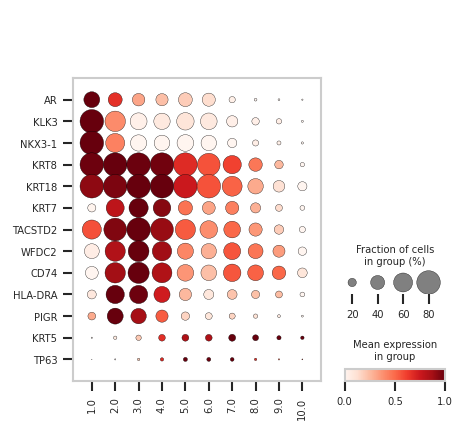

In [66]:
gene_markers = [
    'AR',
    'KLK3','NKX3-1',
    'KRT8','KRT18','KRT7',
    'TACSTD2','WFDC2',
    'CD74','HLA-DRA',
    'PIGR',
    'KRT5', 'TP63',
]

adata.obs['decile_cat'] = pd.Categorical(adata.obs['decile'])

sc.tl.dendrogram(adata,groupby='decile_cat')
fig, ax = plt.subplots(figsize=(4,4),dpi=120)
sc.pl.dotplot(adata,
 groupby='decile_cat',
 var_names=gene_markers,
 standard_scale = 'var',
 #dendrogram=True, 
 use_raw=False, 
 layer='log1p',
 swap_axes=True,
 dot_max=0.8,
 ax = ax, 
 show=False)
plt.show()


In [28]:
# Ensure decile is categorical for grouping
adata.obs['decile_cat'] = pd.Categorical(adata.obs['decile'])

# Compute top genes per decile
sc.tl.rank_genes_groups(
    adata,
    groupby='decile_cat',
    method='t-test',   # can also use 'wilcoxon' or 'logreg'
    use_raw=False,
    layer='log1p'
)


In [54]:

deg_df = sc.get.rank_genes_groups_df(adata,log2fc_min=0.5, pval_cutoff=0.05,group=None)


In [59]:
deg_df[deg_df['names'].isin(['PIGR','CD74','HLA-DRA','HLA-A','KRT5','KRT15'])]

,group,names,scores,logfoldchanges,pvals,pvals_adj
10224,2.0,HLA-A,30.899982,1.163387,1.123382e-191,1.612084e-189
10352,2.0,PIGR,28.564672,1.516217,3.260600e-165,2.718305e-163
10516,2.0,HLA-DRA,26.092001,1.135575,1.711218e-140,9.460695e-139
11132,2.0,CD74,19.746820,0.883480,1.627089e-83,3.880925e-82
22333,3.0,HLA-A,31.702124,1.196795,1.038452e-200,5.145432e-198
22535,3.0,CD74,25.802736,1.123609,1.205520e-137,1.246384e-135
22547,3.0,HLA-DRA,25.579708,1.120534,2.034057e-135,2.000613e-133
22575,3.0,PIGR,25.076984,1.333382,3.390943e-130,2.978246e-128
33235,4.0,HLA-A,19.833847,0.790608,3.092816e-84,1.289213e-81
33420,4.0,CD74,16.464851,0.737608,2.656580e-59,2.746632e-57


In [ ]:
gene_markers = [
    #'KLK3','NKX3-1',
    'ACPP', 'IL1R1',
    'MSMB','NKX3-1',
    'KLK4',
    'AMACR', 'ERG',
    'PCA3', 'SPINK1',
    'GREM2', 'KLK13',
    'CHGA', 'INSM1',
    'SEMG1', 'SEMG2',
    'SERPINB3','SERPINB4',
    'MGP','HLA-DRA',
    'MMP7', 'PIGR',
    'KRT5', 'TP63',
]


sc.tl.dendrogram(adata,groupby='celltype_leiden')
fig, ax = plt.subplots(figsize=(4,8),dpi=120)
sc.pl.dotplot(adata,
 groupby='celltype_leiden',
 var_names=gene_markers,
 categories_order = celltype_order,
 standard_scale = 'var',
 #dendrogram=True, 
 use_raw=False, 
 layer='log1p',
 swap_axes=True,
 dot_max=0.8,
 ax = ax, 
 show=False)
plt.show()
